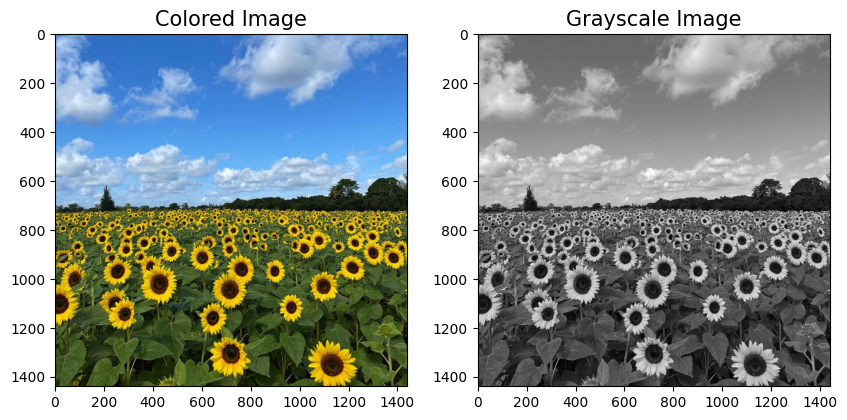

In [24]:
import numpy as np
from skimage.io import imshow, imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

sample = imread('the_berry_farms_sunflower_field.jpeg')
sample_g = rgb2gray(sample)

# Plotting the image to visualize
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sample)
ax[1].imshow(sample_g,cmap='gray')
ax[0].set_title('Colored Image',fontsize=15)
ax[1].set_title('Grayscale Image',fontsize=15)
plt.show()

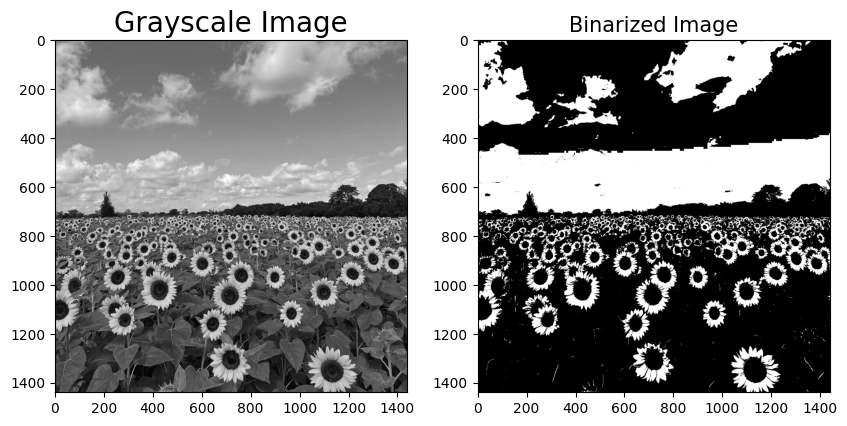

In [25]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sample_b = sample_g > 0.6
ax[0].set_title('Grayscale Image',fontsize=20)
ax[0].imshow(sample_g,cmap='gray')
ax[1].set_title('Binarized Image',fontsize=15)
ax[1].imshow(sample_b,cmap='gray')

Largest Blob Parameters:
Center (x, y): (491.0, 195.0)
Radius: 42.42640687119285
Area: 30.0


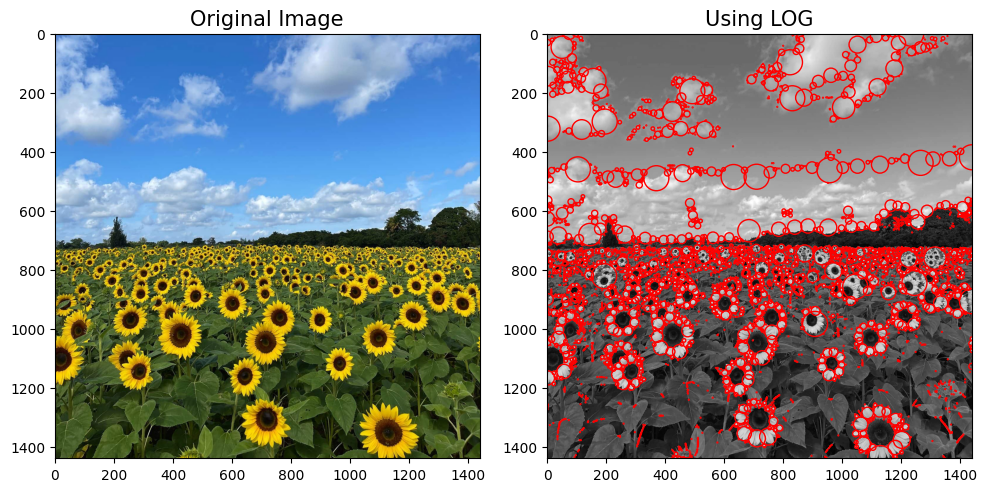

In [28]:
from skimage.feature import blob_log
import matplotlib.pyplot as plt
import numpy as np

# Perform blob detection using LOG method
blobs = blob_log(sample_b, max_sigma=30, threshold=0.01)

largest_blob = None
largest_area = -1

# Iterate through the detected blobs to find the largest blob
for blob in blobs:
    y, x, area = blob
    if area > largest_area:
        largest_area = area
        largest_blob = blob

# Getting parameters of the largest blob
if largest_blob is not None:
    y, x, largest_area = largest_blob
    radius = largest_area * np.sqrt(2)  # Calculating the radius
    
    # Print the parameters of the largest blob
    print("Largest Blob Parameters:")
    print(f"Center (x, y): ({x}, {y})")
    print(f"Radius: {radius}")
    print(f"Area: {largest_area}")

# Plot the original image and the blob detected image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Original Image', fontsize=15)
ax[0].imshow(sample, cmap='gray')

ax[1].imshow(sample_g, cmap='gray')
for blob in blobs:
    y, x, area = blob
    ax[1].add_patch(plt.Circle((x, y), area * np.sqrt(2), color='r', fill=False))

ax[1].set_title('Using LOG', fontsize=15)
plt.tight_layout()
plt.show()

# Question 2

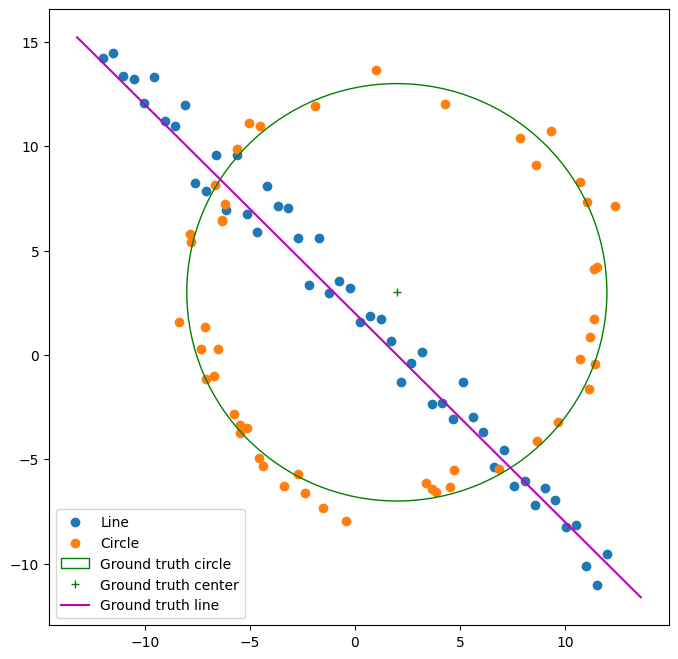

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b0 = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b0 + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

r_ground = r
# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b0
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.499631748762774e-08
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.458975213206894e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.330142015848532
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.910944943352291e-09
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.703491708644325e-10
            Iterations: 8
            Functio

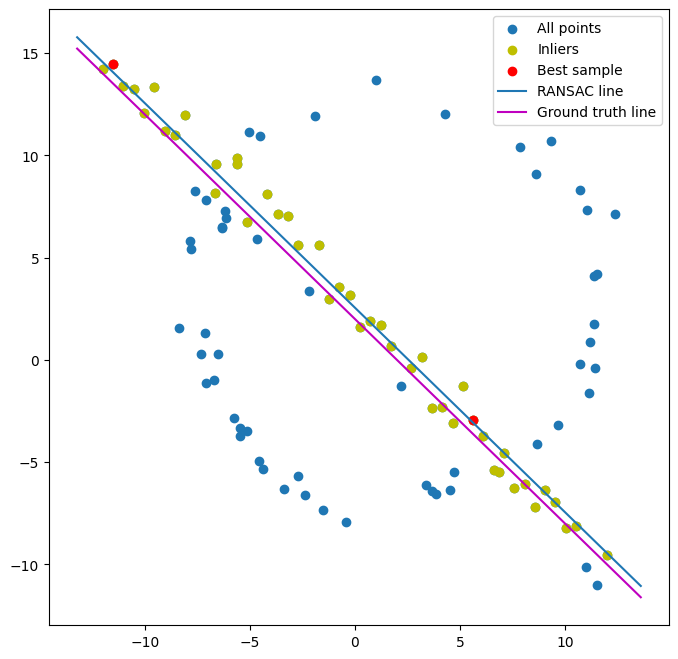

In [34]:
import math
from scipy.optimize import minimize

N = X.shape[0]
dataset = X

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)
    return a, b, d

def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*dataset[indices,0] + b*dataset[indices,1] - d))

def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*dataset[:,0] + b*dataset[:,1] - d)
    return error < t

threshold = 1.
required_inliers = 0.4*N 
min_data_points = 2 

inliers_line = []        
max_iterations = 50
iteration = 0
best_model_line = []     
best_error = np.inf
best_sample_line = []   
res_only_with_sample = [] 
best_inliers_line = []   

while iteration < max_iterations:   
    indices = np.random.randint(0, N, min_data_points) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(dataset, res.x, threshold) # Computing the inliers

    if inliers_line.sum() > required_inliers:
        x0 = res.x
        # Using inliers computing the new model
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})

        if res.fun < best_error:
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = dataset[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(dataset[:,0],dataset[:,1], label='All points')
ax.scatter(dataset[best_inliers_line,0],dataset[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')

x_min, x_max = ax.get_xlim()
x_ran = np.array([x_min, x_max])
y_ran = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_ran, y_ran,  label='RANSAC line')

x_ = np.array([x_min, x_max])
y_ = m*x_ + b0
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()

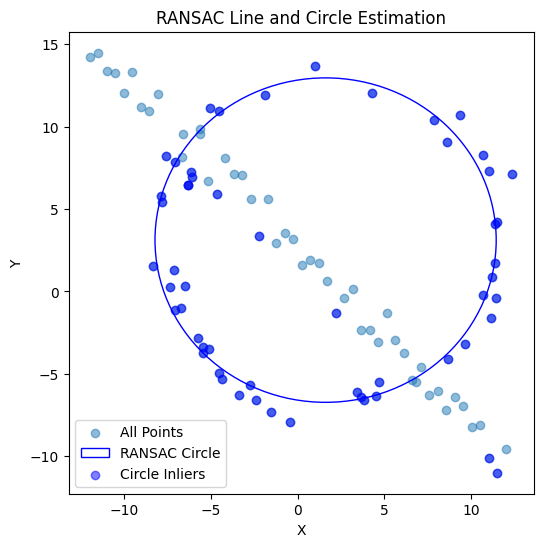

Estimated Circle Parameters: x=1.61, y=3.12, r=9.84


In [35]:
# Subtract the consensus of the best line (remnant)
line_inliers = dataset[best_inliers_line]
X_remnant = dataset[~best_inliers_line]

# RANSAC parameters for circle estimation
max_iterations_circle = 100
inlier_threshold_circle = 0.5  # Adjust this threshold as needed
min_inliers_circle = 3

# Function to estimate circle parameters [x, y, r] from points
def estimate_circle(points):
    # Define the objective function for circle fitting
    def circle_objective(params, points):
        x, y, r = params
        return np.sum((points[:, 0] - x)**2 + (points[:, 1] - y)**2 - r**2)**2

    # Initialize the optimizer with an initial guess for the circle parameters
    initial_guess = [2, 2, 5]  # Adjust the initial guess as needed
    result = minimize(circle_objective, initial_guess, args=(points,), method='Nelder-Mead')

    x, y, r = result.x
    return x, y, r

# Function to calculate the radial error (distance from points to the circle)
def circle_error(params, points):
    x, y, r = params
    distances = np.abs(np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2) - r)
    return distances

# RANSAC algorithm for circle estimation on the remnant
best_circle = None
best_inliers_circle = 0

for _ in range(max_iterations_circle):
    # Randomly select three points
    random_indices = np.random.choice(len(X_remnant), 3, replace=False)
    random_points = X_remnant[random_indices]

    # Estimate the circle parameters [x, y, r]
    x, y, r = estimate_circle(random_points)

    # Calculate the radial error (distance from points to the circle)
    errors = circle_error([x, y, r], X_remnant)

    # Count inliers (points that are within the threshold)
    inliers = np.sum(errors < inlier_threshold_circle)

    if inliers >= min_inliers_circle and inliers > best_inliers_circle:
        best_circle = [x, y, r]
        best_inliers_circle = inliers

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(dataset[:, 0], dataset[:, 1], label='All Points', alpha=0.5)
circle = plt.Circle((best_circle[0], best_circle[1]), best_circle[2], color='b', fill=False, label='RANSAC Circle')
ax.add_patch(circle)
ax.scatter(X_remnant[:, 0], X_remnant[:, 1], label='Circle Inliers', color='b', alpha=0.5)
ax.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('RANSAC Line and Circle Estimation')
plt.show()

# Print the estimated circle parameters
print(f'Estimated Circle Parameters: x={best_circle[0]:.2f}, y={best_circle[1]:.2f}, r={best_circle[2]:.2f}')


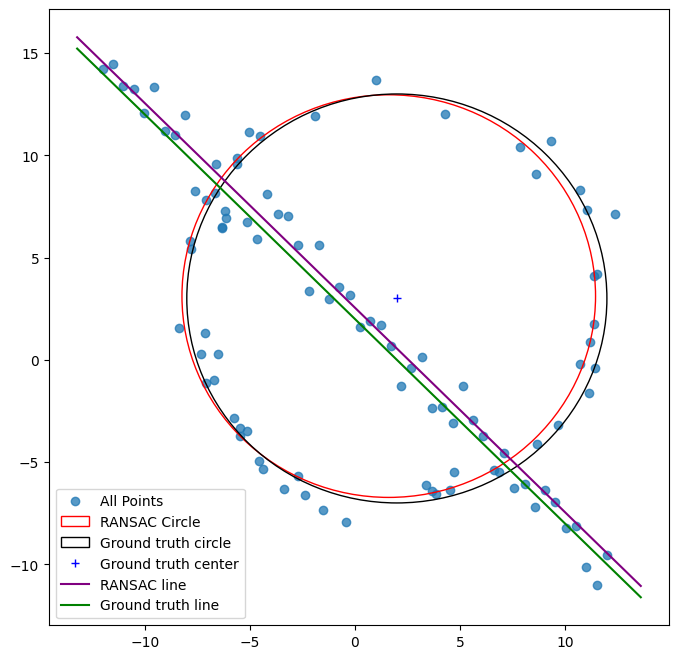

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(dataset[:, 0], dataset[:, 1], label='All Points', alpha = 0.75)
circle = plt.Circle((best_circle[0], best_circle[1]), best_circle[2], color='r', fill=False, label='RANSAC Circle')
ax.add_patch(circle)

circle_gt = plt.Circle((x0_gt, y0_gt), r_ground, color='black', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+b', label='Ground truth center')

#ax.scatter(X_remnant[:, 0], X_remnant[:, 1], label='Circle Inliers', color='y')
plt.plot(x_ran, y_ran, color='purple', label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b0
plt.plot(x_, y_, color='green', label='Ground truth line')
plt.legend()
ax.legend()

# Question 3

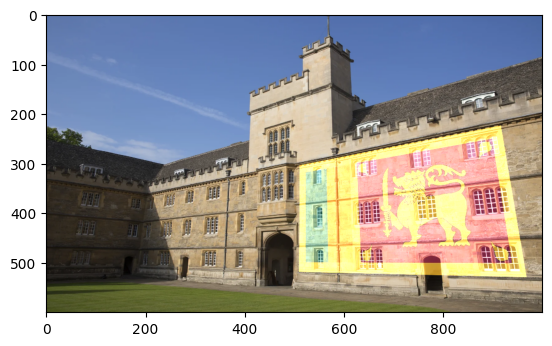

In [40]:
import cv2
import numpy as np

# Function to handle mouse click events
def mouse_callback(event, x, y, flags, param):
    global points
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(points) < 4:
            points.append((x, y))
            cv2.circle(image_copy, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("Select Points", image_copy)
            if len(points) == 4:
                compute_homography()

# Function to compute homography and place the flag
def compute_homography():
    global points
    if len(points) == 4:
        architectural_points = np.array(points, dtype=np.float32)
        flag_points = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)
        homography_matrix, _ = cv2.findHomography(flag_points, architectural_points)
        flag_warped = cv2.warpPerspective(flag_image, homography_matrix, (image.shape[1], image.shape[0]))
        result = cv2.addWeighted(image, 1, flag_warped, 0.7, 0)
        cv2.imshow("Result", result)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB) )

image = cv2.imread('background.jpeg')
flag_image = cv2.imread('flag.jpg')

image = cv2.resize(image, (1000, 600))

# Create a copy of the image for point selection
image_copy = image.copy()

# Create a window for point selection
cv2.namedWindow("Select Points")
cv2.setMouseCallback("Select Points", mouse_callback)

# List to store selected points
points = []

# Main loop
while True:
    cv2.imshow("Select Points", image_copy)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

cv2.destroyAllWindows()


# Question 4

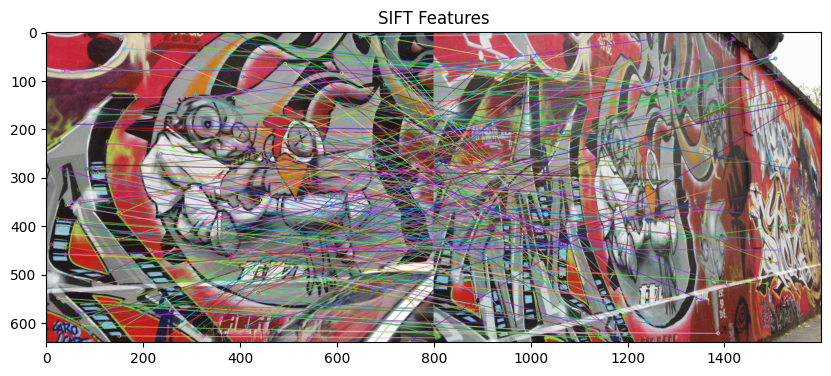

In [44]:
import cv2 as cv
import matplotlib.pyplot as plt
im1, im5 = cv.imread("graffiti images\img1.ppm"), cv.imread("graffiti images\img5.ppm")

sift = cv.SIFT_create()
key_points_1, descriptors_1 = sift.detectAndCompute(im1,None) #sifting
key_points_2, descriptors_2 = sift.detectAndCompute(im5,None)
bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)  #feature matching
matches = sorted(bf_match.match(descriptors_1, descriptors_2), key = lambda x:x.distance)

im = cv.drawMatches(im1, key_points_1, im5, key_points_2, matches[:250], im5, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)  #draw lines between the matching features of two images
fig, ax = plt.subplots(figsize=(10,10))
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
ax.set_title("SIFT Features"), ax.imshow(im)
plt.show()

Computed Homography =  [[ 6.32263200e-01  4.84235039e-02  2.22075179e+02]
 [ 2.29731111e-01  1.14414839e+00 -2.46178043e+01]
 [ 5.09689102e-04 -7.58547765e-05  1.00000000e+00]]
Provided Homography =     6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



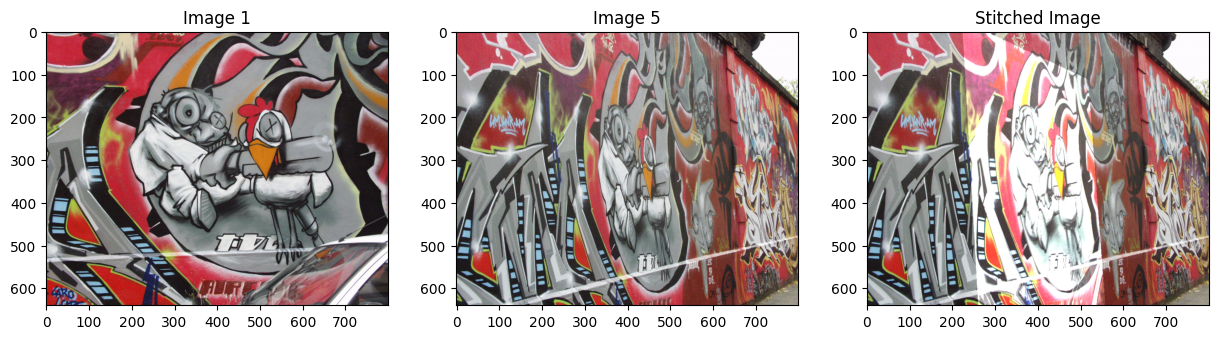

In [42]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load images
img1 = cv.imread("graffiti images\img1.ppm")
img2 = cv.imread("graffiti images\img2.ppm")
img3 = cv.imread("graffiti images\img3.ppm")
img4 = cv.imread("graffiti images\img4.ppm")
img5 = cv.imread("graffiti images\img5.ppm")

# Convert images to grayscale
gray_img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray_img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
gray_img3 = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)
gray_img4 = cv.cvtColor(img4, cv.COLOR_BGR2GRAY)
gray_img5 = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

gray_imgs = [gray_img1, gray_img2, gray_img3, gray_img4, gray_img5]

# Function to generate random numbers
def random_number(n, t):
    rand_nums = np.random.randint(n, size=t)
    counts = np.zeros(np.shape(rand_nums))

    for i in range(len(rand_nums)):
        counts[i] = np.sum(rand_nums == rand_nums[i])

    if np.sum(counts) == len(counts):
        return rand_nums
    else:
        return random_number(n, t)

# Function to compute Homography matrix
def compute_homography(p1, p2):
    x1, y1, x2, y2, x3, y3, x4, y4 = p2[0], p2[1], p2[2], p2[3], p2[4], p2[5], p2[6], p2[7]
    x1T, x2T, x3T, x4T = p1[0], p1[1], p1[2], p1[3]
    zero_matrix = np.array([[0], [0], [0]])

    matrix_A = np.concatenate((np.concatenate((zero_matrix.T, x1T, -y1 * x1T), axis=1),
                              np.concatenate((x1T, zero_matrix.T, -x1 * x1T), axis=1),
                              np.concatenate((zero_matrix.T, x2T, -y2 * x2T), axis=1),
                              np.concatenate((x2T, zero_matrix.T, -x2 * x2T), axis=1),
                              np.concatenate((zero_matrix.T, x3T, -y3 * x3T), axis=1),
                              np.concatenate((x3T, zero_matrix.T, -x3 * x3T), axis=1),
                              np.concatenate((zero_matrix.T, x4T, -y4 * x4T), axis=1),
                              np.concatenate((x4T, zero_matrix.T, -x4 * x4T), axis=1)),
                             axis=0, dtype=np.float64)

    W, v = np.linalg.eig((matrix_A.T) @ matrix_A)
    min_index = np.argmin(W)
    temph = v[:, min_index]
    H = temph.reshape((3, 3))
    return H

# RANSAC parameters
p_value = 0.99
s = 4
epsilon = 0.5
N = int(np.ceil(np.log(1 - p_value) / np.log(1 - ((1 - epsilon) ** s))))
Hs = []

# Loop through the images and compute Homography matrices
for i in range(4):
    sift = cv.SIFT_create()
    key_points_1, descriptors_1 = sift.detectAndCompute(gray_imgs[i], None)
    key_points_2, descriptors_2 = sift.detectAndCompute(gray_imgs[i + 1], None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = sorted(bf_match.match(descriptors_1, descriptors_2), key=lambda x: x.distance)

    source_points = [key_points_1[k.queryIdx].pt for k in matches]
    destination_points = [key_points_2[k.trainIdx].pt for k in matches]
    threshold, best_inliers, best_H = 2, 0, 0

    for j in range(N):
        random_indices = random_number(len(source_points) - 1, 4)
        sampled_source_points = []
        sampled_destination_points = []

        for k in range(4):
            sampled_source_points.append(np.array([[source_points[random_indices[k]][0], source_points[random_indices[k]][1], 1]]))
            sampled_destination_points.append(destination_points[random_indices[k]][0])
            sampled_destination_points.append(destination_points[random_indices[k]][1])

        H = compute_homography(sampled_source_points, sampled_destination_points)

        inliers = 0
        for k in range(len(source_points)):
            X = [source_points[k][0], source_points[k][1], 1]
            HX = H @ X
            HX /= HX[-1]
            err = np.sqrt(np.power(HX[0] - destination_points[k][0], 2) + np.power(HX[1] - destination_points[k][1], 2))
            if err < threshold:
                inliers += 1

        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H

    Hs.append(best_H)

# Compute the final Homography matrix
H1_to_5 = Hs[3] @ Hs[2] @ Hs[1] @ Hs[0]
H1_to_5 /= H1_to_5[-1][-1]

# Display results
print("Computed Homography = ", H1_to_5)
print("Provided Homography = ", open("graffiti images\H1to5p", 'r').read())

transformed_image = cv.warpPerspective(img1, H1_to_5, (np.shape(img5)[1], np.shape(img5)[0]))
final_image = cv.add(img5, transformed_image)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
ax[1].set_title("Image 5")
ax[2].imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))
ax[2].set_title("Stitched Image")
plt.show()